### 1. Data Extraction

In [262]:
# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import pandas as pd
# For saving the response data in CSV format
import csv
# For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata
import time
import statistics
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
import nltk
import string
import re
from nltk.util import ngrams
import sklearn
import emoji

In [2]:
# Use of Bearer Token

os.environ['TOKEN'] = 'AAAAAAAAAAAAAAAAAAAAAOY3eQEAAAAA%2FK0FPI1vVnopel6JTVkr3Xub%2BlE%3Dpbokl1iPkF9foae0YEnAfsmUBt2jsF0DMss8nvElve8Z8dhoVL'
# os.environ['TOKEN'] = 'AAAAAAAAAAAAAAAAAAAAAIu3dQEAAAAAv%2Bz8dWQYjA0ZOWHJlcu%2FFIUiFjA%3Dn54h9wPaU6iRsCwWKAlanfprENYSf98Rbups3bltouPpdDULUf'

In [3]:
# Auth function to retrieve the bearer token from the environment

def auth():
    return os.getenv('TOKEN')

In [4]:
# Creating headers

def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

In [5]:
# Creating URLs

def create_url(keyword, start_date, end_date, max_results = 10):
    
    search_url = "https://api.twitter.com/2/tweets/search/all" #Change to the endpoint you want to collect data from

    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date,
                    'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referencdf,reply_settings,source',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    return (search_url, query_params)

In [6]:
def connect_to_endpoint(url, headers, params, next_token = None):
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [8]:
def append_to_csv_updated(json_response, fileName):

    #A counter variable
    counter = 0

    #Open OR create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    for tweet in json_response['data']:
        
        # We will create a variable for each since some of the keys might not exist for some tweets
        # So we will account for that

        # 1. Author ID
        author_id = tweet['author_id']

        # 2. Time created
        created_at = dateutil.parser.parse(tweet['created_at'])

        # 3. Geolocation
        if ('geo' in tweet):   
            geo = tweet['geo']['place_id']
        else:
            geo = " "

        # 4. Tweet ID
        tweet_id = tweet['id']

        # 5. Language
        lang = tweet['lang']

        # 6. Tweet metrics
        retweet_count = tweet['public_metrics']['retweet_count']
        reply_count = tweet['public_metrics']['reply_count']
        like_count = tweet['public_metrics']['like_count']
        quote_count = tweet['public_metrics']['quote_count']

        # 7. source
        source = tweet['source']

        # 8. Tweet text
        text = tweet['text']
        
        # 9. Possibly sensitive
        reply_settings = tweet['reply_settings']
        
        # 10. Conversation id 
        conversation_id = tweet['conversation_id']
        
        # 11. Referenced tweets type
        if ('referencdf' in tweet):
            referencdf_type = tweet['referencdf']
        else:
            referencdf_type = ""
        
        # 12. Referenced tweets id
        if ('referencdf' in tweet):
            referencdf_id = tweet['referencdf']
        else:
            referencdf_id = ""
        
        # 13. Reply to
        if ('in_reply_to_user_id' in tweet):
            in_reply_to_user_id = tweet['in_reply_to_user_id']
        else:
            in_reply_to_user_id = ""
        
        
        # Assemble all data in a list
        res = [author_id, created_at, geo, tweet_id, lang, like_count, quote_count, reply_count, retweet_count,\
               source, text, reply_settings, conversation_id, referencdf_type, referencdf_id, \
               in_reply_to_user_id]
        
       
        # Append the result to the CSV file
        csvWriter.writerow(res)
        counter += 1

    # When done, close the CSV file
    csvFile.close()

    # Print the number of tweets for this iteration
    print("# of Tweets added from this response: ", counter) 

In [9]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
now = datetime.now()
current_datetime = now.strftime("%d%m_%H%M%S")
filename = 'data' + current_datetime + '.csv'
filename

'data0108_164439.csv'

In [10]:
# Modifying the query based on the parameters
#Inputs for tweets
bearer_token = auth()
headers = create_headers(bearer_token)
keyword = "erectile dysfunction lang:en"

start_list = []
end_list = []

date = datetime(2017, 1, 1)
start_date = date


for i in range(53):
    start_date_formatted = start_date.isoformat() + '.000Z'
    start_list.append(start_date_formatted)

    end_date = start_date + relativedelta(months=1) - relativedelta(days=1)
    end_date_formatted = end_date.isoformat() + '.000Z'
    end_list.append(end_date_formatted)

    start_date += relativedelta(months=1)


max_results = 500

#Total number of tweets we collected from the loop
total_tweets = 0

# Create file
csvFile = open(filename, "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

#Create headers for the data you want to save, in this example, we only want save these columns in our dataset
csvWriter.writerow(['author id', 'created_at', 'geo', 'id','lang', 'like_count', 'quote_count', \
                    'reply_count','retweet_count','source','tweet','reply_settings', 'conversation_id', \
                    'referencdf_type', 'referencdf_id', 'in_reply_to_user_id'])
csvFile.close()

for i in range(0,len(start_list)):

    # Inputs
    count = 0 # Counting tweets per time period
    max_count = 100 # Max tweets per time period
    flag = True
    next_token = None
    
    # Check if flag is true
    while flag:
        # Check if max_count reached
        if count >= max_count:
            break
        print("-------------------")
        print("Token: ", next_token)
        url = create_url(keyword, start_list[i],end_list[i], max_results)
        json_response = connect_to_endpoint(url[0], headers, url[1], next_token)
        result_count = json_response['meta']['result_count']

        if 'next_token' in json_response['meta']:
            # Save the token to use for next call
            next_token = json_response['meta']['next_token']
            print("Next Token: ", next_token)
            if result_count is not None and result_count > 0 and next_token is not None:
                print("Start Date: ", start_list[i])
                append_to_csv_updated(json_response, filename)
                count += result_count
                total_tweets += result_count
                print("Total # of Tweets added: ", total_tweets)
                print("-------------------")
                time.sleep(5)                
        # If no next token exists
        else:
            if result_count is not None and result_count > 0:
                print("-------------------")
                print("Start Date: ", start_list[i])
                append_to_csv_updated(json_response, filename)
                count += result_count
                total_tweets += result_count
                print("Total # of Tweets added: ", total_tweets)
                print("-------------------")
                time.sleep(5)
            
            #Since this is the final request, turn flag to false to move to the next time period.
            flag = False
            next_token = None
        time.sleep(5)
print("Total number of results: ", total_tweets)

-------------------
Token:  None
Endpoint Response Code: 200
Next Token:  1jzu9lk96gu5npw3j426xzdxf614dc1z0d5t4r071ksd
Start Date:  2017-01-01T00:00:00.000Z
# of Tweets added from this response:  491
Total # of Tweets added:  491
-------------------
-------------------
Token:  None
Endpoint Response Code: 200
Next Token:  1jzu9lk96gu5npw3j71yw5bazyho8whmtphqaid4dpbx
Start Date:  2017-02-01T00:00:00.000Z
# of Tweets added from this response:  488
Total # of Tweets added:  979
-------------------
-------------------
Token:  None
Endpoint Response Code: 200
Next Token:  1jzu9lk96gu5npw3ja2kwxtiz7qu4kvt2ra07kxqovb1
Start Date:  2017-03-01T00:00:00.000Z
# of Tweets added from this response:  489
Total # of Tweets added:  1468
-------------------
-------------------
Token:  None
Endpoint Response Code: 200
Next Token:  1jzu9lk96gu5npw3jd2da20ogafd2kpfloh22196ifel
Start Date:  2017-04-01T00:00:00.000Z
# of Tweets added from this response:  471
Total # of Tweets added:  1939
------------------

-------------------
Token:  None
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fnm91wyyrrcs3zy7alrggf5ziufyil
Start Date:  2019-10-01T00:00:00.000Z
# of Tweets added from this response:  446
Total # of Tweets added:  16342
-------------------
-------------------
Token:  None
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fo6ve98rqrgp6lv5yb4s1k1vkvhv25
Start Date:  2019-11-01T00:00:00.000Z
# of Tweets added from this response:  479
Total # of Tweets added:  16821
-------------------
-------------------
Token:  None
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fo6yegcipltm3zzv9aqlolu95izypp
Start Date:  2019-12-01T00:00:00.000Z
# of Tweets added from this response:  478
Total # of Tweets added:  17299
-------------------
-------------------
Token:  None
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fo71enkjfg85ppskhrjem8k6a5pp4t
Start Date:  2020-01-01T00:00:00.000Z
# of Tweets added from this response:  440
Total # of Tweets added:  17739
--------

### 2. Data Wrangling
### <ensp> 2.a. Cleaning
#### 2.a.i Handling duplicate tweets:

In [263]:
filename = 'data0108_164439.csv'
df_ed = pd.read_csv(filename)

In [264]:
df_ed.head()

,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,reply_settings,conversation_id,referenced_tweets_type,referenced_tweets_id,in_reply_to_user_id
0,72687927,2017-01-30 23:59:54+00:00,,826218412087058432,en,0,0,0,0,Twitter Web Client,Erectile Dysfunction Download - https://t.co/2...,everyone,826218412087058432,NaN,NaN,NaN
1,810231726396080128,2017-01-30 23:50:19+00:00,,826216000412647424,en,0,0,0,0,WordPress.com,Could acupuncture cure erectile dysfunction? h...,everyone,826216000412647424,NaN,NaN,NaN
2,21332359,2017-01-30 23:49:10+00:00,,826215710443593731,en,0,0,0,13,Twitter Web App,RT @MensHealthMag: The invisible health condit...,everyone,826215710443593731,"[{'type': 'retweeted', 'id': '8261827083049533...","[{'type': 'retweeted', 'id': '8261827083049533...",NaN
3,2152440722,2017-01-30 23:45:14+00:00,,826214720780722176,en,1,0,0,0,dlvr.it,Could acupuncture cure erectile dysfunction? h...,everyone,826214720780722176,NaN,NaN,NaN
4,2891120914,2017-01-30 23:45:11+00:00,,826214708512296960,en,1,0,0,0,dlvr.it,Could acupuncture cure erectile dysfunction? h...,everyone,826214708512296960,NaN,NaN,NaN


In [265]:
df = df_ed[df_ed.referenced_tweets_type.isna()]

In [266]:
print(f'Count of tweets for ED: {len(df_ed)}')

Count of tweets for ED: 24632


In [267]:
df.head()

,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,reply_settings,conversation_id,referenced_tweets_type,referenced_tweets_id,in_reply_to_user_id
0,72687927,2017-01-30 23:59:54+00:00,,826218412087058432,en,0,0,0,0,Twitter Web Client,Erectile Dysfunction Download - https://t.co/2...,everyone,826218412087058432,NaN,NaN,NaN
1,810231726396080128,2017-01-30 23:50:19+00:00,,826216000412647424,en,0,0,0,0,WordPress.com,Could acupuncture cure erectile dysfunction? h...,everyone,826216000412647424,NaN,NaN,NaN
3,2152440722,2017-01-30 23:45:14+00:00,,826214720780722176,en,1,0,0,0,dlvr.it,Could acupuncture cure erectile dysfunction? h...,everyone,826214720780722176,NaN,NaN,NaN
4,2891120914,2017-01-30 23:45:11+00:00,,826214708512296960,en,1,0,0,0,dlvr.it,Could acupuncture cure erectile dysfunction? h...,everyone,826214708512296960,NaN,NaN,NaN
5,1956941058,2017-01-30 23:44:02+00:00,,826214419982143488,en,1,0,0,0,IFTTT,Could acupuncture cure erectile dysfunction?\n...,everyone,826214419982143488,NaN,NaN,NaN


In [268]:
print(f'Count of tweets for ED after removing the duplicates: {len(df)}')

Count of tweets for ED after removing the duplicates: 9728


#### 2.a.iv Removal of \n, \t, \&gt;

In [269]:
df['tweet'] = df['tweet'].apply(lambda x: x.replace('&gt;|\n|\t', ''))

/var/folders/jl/0m09msdj31314q0x_w0mcf5c0000gn/T/ipykernel_8675/2617722484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet'] = df['tweet'].apply(lambda x: x.replace('&gt;|\n|\t', ''))


#### 2.a.ii Hyperlinks:

In [270]:
def presence(x,text):
    if text in x:
        return 1
    else:
        return 0

In [271]:
df['hyperlink_tag']=df['tweet'].apply(lambda x: presence(x,'http'))

/var/folders/jl/0m09msdj31314q0x_w0mcf5c0000gn/T/ipykernel_8675/192578393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hyperlink_tag']=df['tweet'].apply(lambda x: presence(x,'http'))


In [272]:
df['hyperlink_tag'].value_counts()

1    7210
0    2518
Name: hyperlink_tag, dtype: int64

In [273]:
df['Tweet_exc_link']=df['tweet'].apply(lambda x: re.sub(r"http\S+|www.\S+|Https.\S+", "",x))
df['Tweet_inc_link']=df['tweet'].apply(lambda x: re.findall("(http\S+|www.\S+|Https.\S+)",x))
df['Tweet_inc_link']=df['Tweet_inc_link'].apply(lambda x: str(x).replace("[","").replace("]","").strip())

/var/folders/jl/0m09msdj31314q0x_w0mcf5c0000gn/T/ipykernel_8675/3729918035.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tweet_exc_link']=df['tweet'].apply(lambda x: re.sub(r"http\S+|www.\S+|Https.\S+", "",x))
/var/folders/jl/0m09msdj31314q0x_w0mcf5c0000gn/T/ipykernel_8675/3729918035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tweet_inc_link']=df['tweet'].apply(lambda x: re.findall("(http\S+|www.\S+|Https.\S+)",x))
/var/folders/jl/0m09msdj31314q0x_w0mcf5c0000gn/T/ipykernel_8675/3729918

In [274]:
df.head()

,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,reply_settings,conversation_id,referenced_tweets_type,referenced_tweets_id,in_reply_to_user_id,hyperlink_tag,Tweet_exc_link,Tweet_inc_link
0,72687927,2017-01-30 23:59:54+00:00,,826218412087058432,en,0,0,0,0,Twitter Web Client,Erectile Dysfunction Download - https://t.co/2...,everyone,826218412087058432,NaN,NaN,NaN,1,Erectile Dysfunction Download - #iTunes #hypn...,'https://t.co/2DOzGXrbVl'
1,810231726396080128,2017-01-30 23:50:19+00:00,,826216000412647424,en,0,0,0,0,WordPress.com,Could acupuncture cure erectile dysfunction? h...,everyone,826216000412647424,NaN,NaN,NaN,1,Could acupuncture cure erectile dysfunction?,"'https://t.co/B0HqZeMgdy', 'https://t.co/mwnHs..."
3,2152440722,2017-01-30 23:45:14+00:00,,826214720780722176,en,1,0,0,0,dlvr.it,Could acupuncture cure erectile dysfunction? h...,everyone,826214720780722176,NaN,NaN,NaN,1,Could acupuncture cure erectile dysfunction?,"'https://t.co/C0XlVKmnGB', 'https://t.co/4I6fh..."
4,2891120914,2017-01-30 23:45:11+00:00,,826214708512296960,en,1,0,0,0,dlvr.it,Could acupuncture cure erectile dysfunction? h...,everyone,826214708512296960,NaN,NaN,NaN,1,Could acupuncture cure erectile dysfunction?,"'https://t.co/q3RiaKo4HE', 'https://t.co/L2lIN..."
5,1956941058,2017-01-30 23:44:02+00:00,,826214419982143488,en,1,0,0,0,IFTTT,Could acupuncture cure erectile dysfunction?\n...,everyone,826214419982143488,NaN,NaN,NaN,1,Could acupuncture cure erectile dysfunction?\n...,"'https://t.co/EG6mffU86k', 'https://t.co/UYAwz..."


#### 2.a.iii Hashtag removal:

In [275]:
df['Tweet_exc_hash']=df['Tweet_exc_link'].apply(lambda x: x.replace('#','').strip())
df['Tweet_hashtag_inc']=df['Tweet_exc_link'].apply(lambda x: re.findall("#(\S+)",x))
df['Tweet_hashtag_inc']=df['Tweet_hashtag_inc'].apply(lambda x: " ".join(x))

/var/folders/jl/0m09msdj31314q0x_w0mcf5c0000gn/T/ipykernel_8675/1925447993.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tweet_exc_hash']=df['Tweet_exc_link'].apply(lambda x: x.replace('#','').strip())
/var/folders/jl/0m09msdj31314q0x_w0mcf5c0000gn/T/ipykernel_8675/1925447993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tweet_hashtag_inc']=df['Tweet_exc_link'].apply(lambda x: re.findall("#(\S+)",x))
/var/folders/jl/0m09msdj31314q0x_w0mcf5c0000gn/T/ipykernel_8675/1925447993.py:3: Setting

In [276]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [277]:
df['tweet_formatted'] = df['Tweet_exc_hash'].apply(lambda x: emoji.demojize(x))

/var/folders/jl/0m09msdj31314q0x_w0mcf5c0000gn/T/ipykernel_8675/1686721244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet_formatted'] = df['Tweet_exc_hash'].apply(lambda x: emoji.demojize(x))


In [278]:
df.head()

,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,...,conversation_id,referenced_tweets_type,referenced_tweets_id,in_reply_to_user_id,hyperlink_tag,Tweet_exc_link,Tweet_inc_link,Tweet_exc_hash,Tweet_hashtag_inc,tweet_formatted
0,72687927,2017-01-30 23:59:54+00:00,,826218412087058432,en,0,0,0,0,Twitter Web Client,...,826218412087058432,NaN,NaN,NaN,1,Erectile Dysfunction Download - #iTunes #hypn...,'https://t.co/2DOzGXrbVl',Erectile Dysfunction Download - iTunes hypnot...,iTunes hypnotherapy,Erectile Dysfunction Download - iTunes hypnot...
1,810231726396080128,2017-01-30 23:50:19+00:00,,826216000412647424,en,0,0,0,0,WordPress.com,...,826216000412647424,NaN,NaN,NaN,1,Could acupuncture cure erectile dysfunction?,"'https://t.co/B0HqZeMgdy', 'https://t.co/mwnHs...",Could acupuncture cure erectile dysfunction?,,Could acupuncture cure erectile dysfunction?
3,2152440722,2017-01-30 23:45:14+00:00,,826214720780722176,en,1,0,0,0,dlvr.it,...,826214720780722176,NaN,NaN,NaN,1,Could acupuncture cure erectile dysfunction?,"'https://t.co/C0XlVKmnGB', 'https://t.co/4I6fh...",Could acupuncture cure erectile dysfunction?,,Could acupuncture cure erectile dysfunction?
4,2891120914,2017-01-30 23:45:11+00:00,,826214708512296960,en,1,0,0,0,dlvr.it,...,826214708512296960,NaN,NaN,NaN,1,Could acupuncture cure erectile dysfunction?,"'https://t.co/q3RiaKo4HE', 'https://t.co/L2lIN...",Could acupuncture cure erectile dysfunction?,,Could acupuncture cure erectile dysfunction?
5,1956941058,2017-01-30 23:44:02+00:00,,826214419982143488,en,1,0,0,0,IFTTT,...,826214419982143488,NaN,NaN,NaN,1,Could acupuncture cure erectile dysfunction?\n...,"'https://t.co/EG6mffU86k', 'https://t.co/UYAwz...",Could acupuncture cure erectile dysfunction?,,Could acupuncture cure erectile dysfunction?


In [279]:
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [282]:
# Steps for text cleaning 

df = df.astype(str)

#from spellchecker import SpellChecker

def text_cleaning(x):
    norm_text = x[0].upper() + x[1:] # Step I. Normalizing text
    for word in norm_text.split(): # Step II. Handling the contraction text
        if word.lower() in contractions:
            norm_text = norm_text.replace(word, contractions[word.lower()])
    rem_unicode = re.sub(r"[^a-zA-Z0-9 /,?]+", "", norm_text) #Step III. Removing Unicode Characters
#     rem_unicode = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", norm_text) # Step III. Removing unicode characters
    return rem_unicode

#spell = SpellChecker()

df['tweet_formatted'] = df['tweet_formatted'].apply(text_cleaning)
# df['tweet_formatted'] = df['tweet_formatted'].apply(lambda x: spell.correction(x))

In [283]:
df.head()

,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,...,conversation_id,referenced_tweets_type,referenced_tweets_id,in_reply_to_user_id,hyperlink_tag,Tweet_exc_link,Tweet_inc_link,Tweet_exc_hash,Tweet_hashtag_inc,tweet_formatted
0,72687927,2017-01-30 23:59:54+00:00,,826218412087058432,en,0,0,0,0,Twitter Web Client,...,826218412087058432,nan,nan,nan,1,Erectile Dysfunction Download - #iTunes #hypn...,'https://t.co/2DOzGXrbVl',Erectile Dysfunction Download - iTunes hypnot...,iTunes hypnotherapy,Erectile Dysfunction Download iTunes hypnoth...
1,810231726396080128,2017-01-30 23:50:19+00:00,,826216000412647424,en,0,0,0,0,WordPress.com,...,826216000412647424,nan,nan,nan,1,Could acupuncture cure erectile dysfunction?,"'https://t.co/B0HqZeMgdy', 'https://t.co/mwnHs...",Could acupuncture cure erectile dysfunction?,,Could acupuncture cure erectiledysfunction?
3,2152440722,2017-01-30 23:45:14+00:00,,826214720780722176,en,1,0,0,0,dlvr.it,...,826214720780722176,nan,nan,nan,1,Could acupuncture cure erectile dysfunction?,"'https://t.co/C0XlVKmnGB', 'https://t.co/4I6fh...",Could acupuncture cure erectile dysfunction?,,Could acupuncture cure erectile dysfunction?
4,2891120914,2017-01-30 23:45:11+00:00,,826214708512296960,en,1,0,0,0,dlvr.it,...,826214708512296960,nan,nan,nan,1,Could acupuncture cure erectile dysfunction?,"'https://t.co/q3RiaKo4HE', 'https://t.co/L2lIN...",Could acupuncture cure erectile dysfunction?,,Could acupuncture cure erectile dysfunction?
5,1956941058,2017-01-30 23:44:02+00:00,,826214419982143488,en,1,0,0,0,IFTTT,...,826214419982143488,nan,nan,nan,1,Could acupuncture cure erectile dysfunction?\n...,"'https://t.co/EG6mffU86k', 'https://t.co/UYAwz...",Could acupuncture cure erectile dysfunction?,,Could acupuncture cure erectile dysfunction?


In [284]:
df['tweet_formatted_lower'] = df['tweet_formatted'].str.lower()

In [285]:
df['interrogative']=df['tweet'].apply(lambda x:1 if '?' in x else 0)

In [286]:
df['interrogative'].value_counts()

0    8478
1    1250
Name: interrogative, dtype: int64

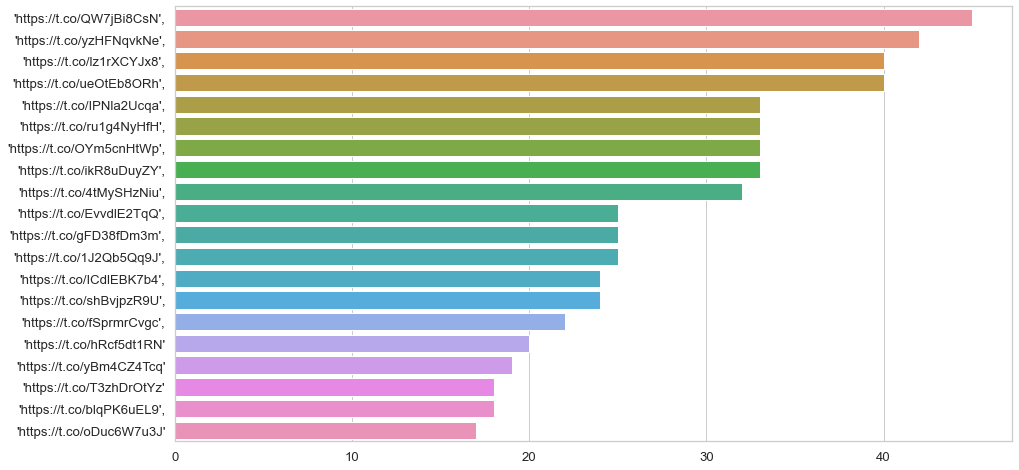

In [287]:
# Checking the distribution of the links mentioned
from collections import  Counter
from nltk.corpus import stopwords

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:20]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(15,8))
    sns.barplot(x=y,y=x)

plot_top_non_stopwords_barchart(df['Tweet_inc_link'])

# Explore more such analysis here - https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

### Tokenization & Lemmatization

In [288]:
df['tokenized']=df['tweet_formatted_lower'].apply(lambda x:nltk.word_tokenize(x))

In [289]:
# initializing wordnet libraries

nltk.download('wordnet')
lemmatizer=nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vanibhat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [290]:
df['lemmatized']=df['tokenized'].apply(lambda x:[lemmatizer.lemmatize(i) for i in x])

#### Stop word elimination

In [291]:
# initializing Stop words libraries

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vanibhat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [292]:
stopwords=nltk.corpus.stopwords
df['lemmatized']=df['lemmatized'].apply(lambda x: " ".join([i for i in x if i.lower() not in stopwords.words('english')]))

#### Ngram

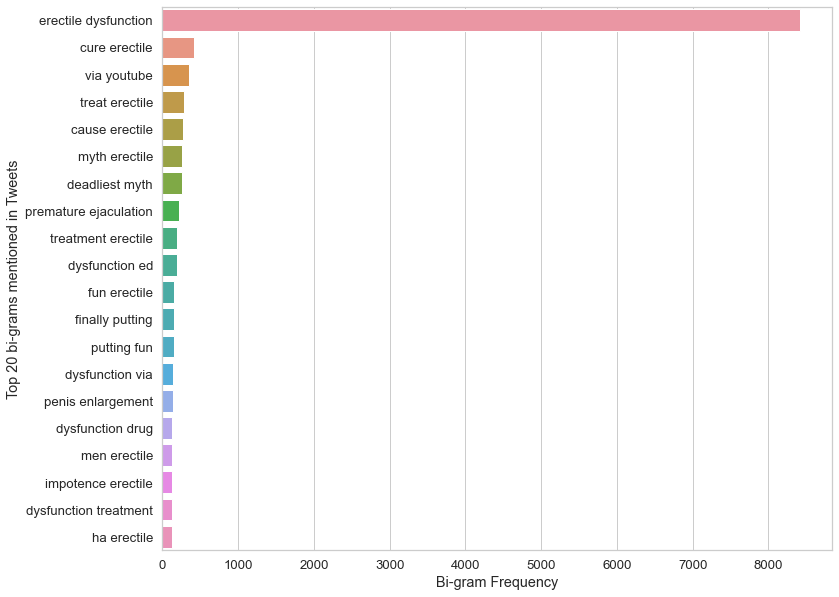

In [293]:
#Bi-grams 
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(text,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(12,10))
    plt.xlabel("Bi-gram Frequency")
    plt.ylabel("Top 20 bi-grams mentioned in Tweets")
    sns.barplot(x=y,y=x)


plot_top_ngrams_barchart(df['lemmatized'],2)

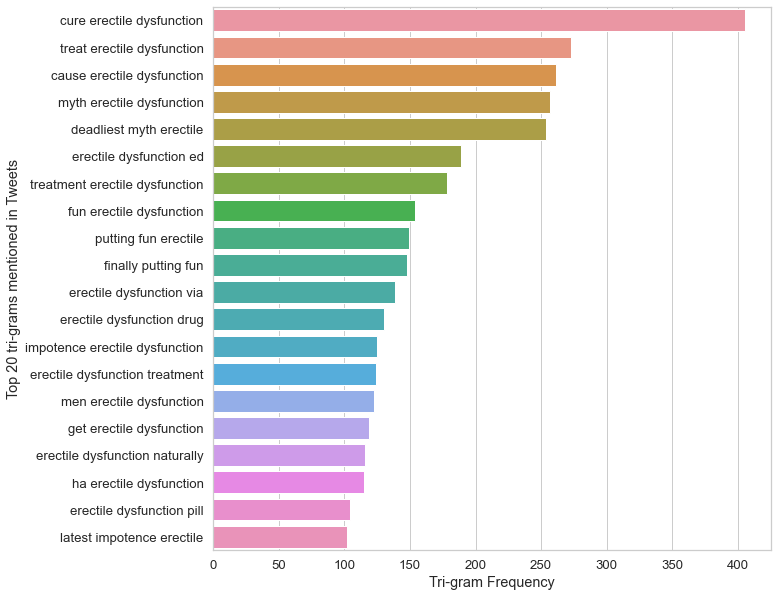

In [294]:
#Tri-grams 

def plot_top_ngrams_barchart(text, n=3):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(text,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(10,10))
    plt.xlabel("Tri-gram Frequency")
    plt.ylabel("Top 20 tri-grams mentioned in Tweets")
    sns.barplot(x=y,y=x)


plot_top_ngrams_barchart(df['lemmatized'],3)

### Checking emotion type using Polarity & subjectivity

In [295]:
from textblob import TextBlob

In [296]:
def getanalysis(score):
    if score < 0:
        return "negative"
    if score == 0:
        return "neutral"
    if score > 0:
        return "positive"

In [301]:
df['Polarity']=df['tweet_formatted_lower'].apply(lambda x:TextBlob(x).polarity)
df['Subjectivity']=df['tweet_formatted_lower'].apply(lambda x:TextBlob(x).subjectivity)
df['Analysis'] = df.Polarity.apply(getanalysis)

<AxesSubplot:xlabel='Polarity', ylabel='Count'>

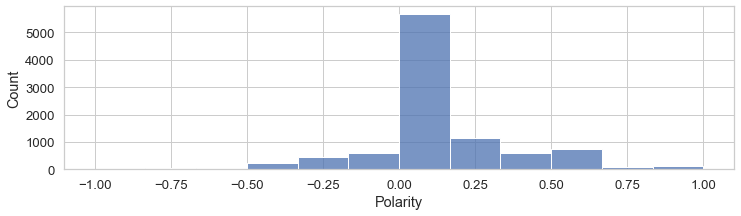

In [302]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 3))
sns.histplot(data = df['Polarity'], legend=False, bins = 12)

<AxesSubplot:xlabel='Subjectivity', ylabel='Count'>

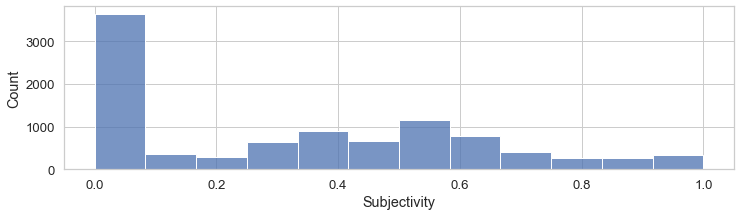

In [303]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 3))
sns.histplot(data = df['Subjectivity'], legend=False, bins = 12)

<AxesSubplot:xlabel='Polarity', ylabel='Subjectivity'>

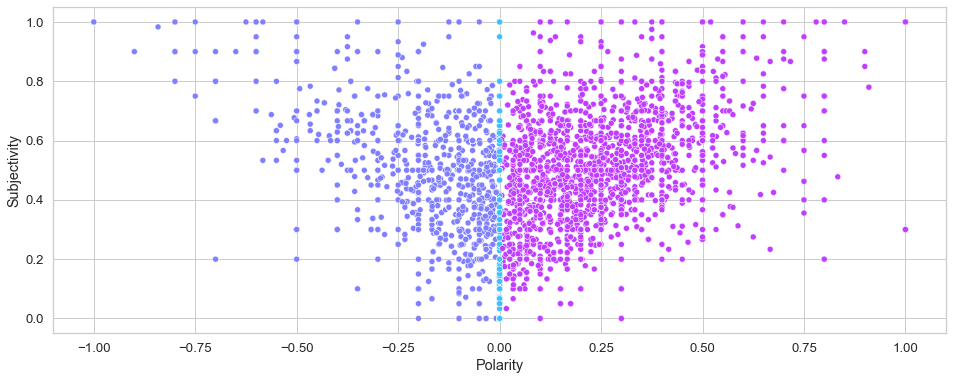

In [304]:
sns.set(font_scale=1.2)
sns.set_style('whitegrid')

plt.figure(figsize=(16, 6))
sns.scatterplot(data=df, x= "Polarity", y= "Subjectivity", 
                     hue='Analysis', 
                     palette='cool', legend=False)

In [305]:
df.Analysis.value_counts()

positive    4164
neutral     4147
negative    1417
Name: Analysis, dtype: int64

Percentage of positive tweets: 42.80%
Percentage of negative tweets: 14.57%
Percentage of neutral tweets: 42.63%


<AxesSubplot:>

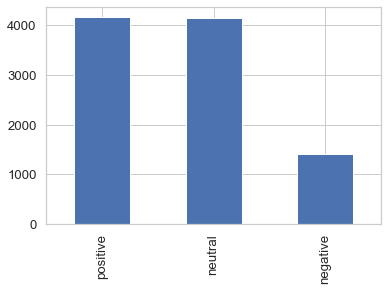

In [306]:
# percentage of positive subjects
ps= df[df.Analysis=="positive"]
pct= (ps.shape[0]/df.shape[0])
print(f'Percentage of positive tweets: {pct*100:.2f}%')

# percentage of negative subjects
ps= df[df.Analysis=="negative"]
pct= (ps.shape[0]/df.shape[0])
pct
print(f'Percentage of negative tweets: {pct*100:.2f}%')

# percentage of neutral subjects
ps= df[df.Analysis=="neutral"]
pct= (ps.shape[0]/df.shape[0])
pct
print(f'Percentage of neutral tweets: {pct*100:.2f}%')

# show the count
df.Analysis.value_counts().plot(kind="bar")

### Emoji Analysis

In [307]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install spacymoji

import spacy
from spacymoji import Emoji

nlp = spacy.load("en_core_web_sm")
emoji = Emoji(nlp)
nlp.add_pipe("emoji", first=True)

nlp.pipe_names

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 14.8 MB/s eta 0:00:0000:0100:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


['emoji',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [308]:
text1 = list(df['tweet'])
#text1

In [309]:
def extract_emojies(x):
  doc = nlp(x['tweet']) #with emojis
  
  emojis = [1 if token._.is_emoji else 0 for token in doc ]
  emoji_tag = [1 if 1 in emojis else 0][0]
  return emoji_tag

df['emoji_tag'] = df.apply(extract_emojies,axis=1)
df['emoji_tag'].value_counts()

0    9098
1     630
Name: emoji_tag, dtype: int64

In [311]:
count = df['emoji_tag'].value_counts()[1]
print(f'Count of tweets with emotions: {count}')

Count of tweets with emotions: 630


In [312]:
df.to_csv('ED_Tweets_formatted.csv')

In [313]:
def extract_emojies(x):
  doc = nlp(x['tweet']) #with emojis 
  emojis = [token.text for token in doc if token._.is_emoji]
  return emojis

emojies_df = df.apply(extract_emojies,axis=1)
#emojies_df.head(30)

In [314]:
emoji_counts = (emojies_df
                .apply(pd.Series) #breaks up the list into seperate columns 
                .stack() #collapses each column into one column
                .value_counts() #counts the frequency of each item
                .rename('Count')
                .sort_values()
                .reset_index()
                .rename(columns={'index':'Emoji'}))
emoji_counts

,Emoji,Count
0,📢,1
1,👽,1
2,▪,1
3,🙅‍♀️,1
4,▶,1
...,...,...
275,👇,40
276,🤣,45
277,😭,78
278,✔,102


In [315]:
emoji_counts.sort_values(by = 'Count', ascending=False)

,Emoji,Count
279,😂,183
278,✔,102
277,😭,78
276,🤣,45
275,👇,40
...,...,...
91,🤩,1
92,⛺,1
93,📙,1
94,👩‍❤️‍💋‍👨,1


In [316]:
emoji_counts.to_csv('ED_Emojis.csv')